---
title: "2023_Kronensicherung_Plesse_Combined_Analyse"
author: "Kyell Jensen"
date: "2024-08-06"
format: pdf
editor: visual
---

# 2023_Kronensicherung_Plesse_Combined_Analyse

## Kombinierte Analyse LineScale3, TreeQinetic und Versuchsaufzeichung

Nutze eine geeignete Python 3.11 Umgebung (z. B. virtuelle Environment).

## Arbeitsumgebung vorbereiten

### IMPORT: Importieren von Standardbibliotheken

Die folgenden Bibliotheken werden importiert, um grundlegende Funktionen für Strukturierung, Datenverarbeitung, Plotting und statistische Auswertung bereit zu stellen.

In [69]:
# Struktur
from pathlib import Path
from typing import Dict, List

# Datenverarbeitung
import json
from IPython.display import Markdown, display
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from slugify import slugify  # Slugify ums strings in standard Formate zu überführen

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Statistik
from scipy.stats import linregress, f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc


### IMPORT: Importiere eigene Packete (hier nur für Plotter und Logger)

In [70]:
from kj_core.utils.latex_export import (
    save_latex_table,
    build_data_dict_df
)

from kj_core.utils.labeling import get_label_from_dict

In [71]:
from kj_core import CoreConfig, PlotManager, get_logger

In [72]:
# Importiere alle Einstellungen aus der project_config.py
from project_config import (
    working_directory,
    data_export_directory,
    latex_export_directory
)

###

In [73]:
CONFIG = CoreConfig(working_directory=f"{working_directory}/combined")
PLOT_MANAGER = PlotManager(CONFIG)
# CONFIG
# PLOT_MANAGER

## IMPORT: Daten Import

Lege Pfade für Daten-Importe, Daten-Exporte etc. fest (ggf. anpassen an eigene Verzeichnisstruktur), ausgelagert in gemeinsame Config für verschiedene Notebooks

In [74]:
filename_dataset = "_dataset_clean.feather"
filename_data_dict = "_data_dict_clean.json"

In [75]:
# Dateien laden
df = pd.read_feather(data_export_directory / filename_dataset)

with open(data_export_directory / filename_data_dict, "r", encoding="utf-8") as f:
    data_dict = json.load(f)

## ANALYSE: Explorative Datenanalyse

In [76]:
# In DataFrame umwandeln
data_dict_df= build_data_dict_df(data_dict)

# In Markdown umwandeln und anzeigen
md_text = data_dict_df.to_markdown(tablefmt="github")
display(Markdown(md_text))

|    | Variable                | Kategorie       | Zeichen                           | Deutsch                              | Datentyp   | Einheit   | Beschreibung                                                              |
|----|-------------------------|-----------------|-----------------------------------|--------------------------------------|------------|-----------|---------------------------------------------------------------------------|
|  0 | id                      | ptq             | ID                                | ID Messung                           | int64      | -         | Eindeutige ID der Messung                                                 |
|  1 | rope_datetime           | ls3             | $t$                               | Zeitstempel                          | object     | -         | Startzeitpunkt der Messung laut Gerät                                     |
|  2 | treatment               | series          | treatment                         | Behandlung                           | category   | -         | Art der KS: \texttt{free}, \texttt{gefa\_dynamic}, \texttt{cobra\_static} |
|  3 | release_force_target    | series          | $F_{\mathrm{release,target}}$     | Vorspannkraft-Soll                   | float64    | kN        | Geplante Vorspannkraft im Zugseil bei Release                             |
|  4 | rope_release            | ls3             | $F_{\mathrm{release}}$            | Vorspannkraft Ist                    | float64    | kN        | Tatsächlich realisierte Vorspannkraft im Zugseil bei Release              |
|  5 | cable_max               | ls3             | $F_{\mathrm{cable, max}}$         | Kraftspitze KS                       | object     | kN        | Maximale gemessene Kraftspitze in der KS                                  |
|  6 | sensor_name             | ptq             | sensor                            | Sensorname                           | object     | -         | Bezeichnung des Elastometers                                              |
|  7 | location                | sensor_position | location                          | Position                             | string     | -         | Position des Sensors am Stamm                                             |
|  8 | direction               | sensor_position | direction                         | Richtung                             | string     | -         | Zug- oder Druckseite                                                      |
|  9 | height                  | sensor_position | $h$                               | Höhe                                 | Float64    | m         | Höhe des Sensors am Stamm                                                 |
| 10 | diameter                | sensor_position | $d$                               | Durchmesser                          | Float64    | cm        | Durchmesser des Stammes                                                   |
| 11 | max_strain              | ptq             | $\Delta L_{\mathrm{max}}$         | Dehnung max. gemessen                | float64    | $\mu$m    | Gemessene maximale absolute Randfaserdehnung                              |
| 12 | max_compression         | ptq             | $\Delta L_{\mathrm{comp,max}}$    | Stauchung max. gemessen              | float64    | $\mu$m    | Gemessene maximale absolute Randfaserstauchung                            |
| 13 | m_amplitude             | ptq_osc         | $mA$                              | Manuelle Amplitude                   | float64    | $\mu$m    | Manuell berechnete Amplitude über den Schwingungsabschnitt                |
| 14 | m_amplitude_2           | ptq_osc         | $mA_2$                            | Manuelle Amplitude 2                 | float64    | $\mu$m    | Manuell berechnete Amplitude zwischen 2. Peak und Minimum                 |
| 15 | initial_amplitude       | ptq_osc         | $A$                               | Anfangsamplitude                     | float64    | $\mu$m    | Initiale Amplitude der angepassten Schwingung                             |
| 16 | damping_coeff           | ptq_osc         | $\delta$                          | Dämpfungskoeffizient                 | float64    | 1/s       | Koeffizient der exponentiellen Dämpfung                                   |
| 17 | frequency_damped        | ptq_osc         | $f_{\mathrm{d}}$                  | Gedämpfte Frequenz                   | float64    | Hz        | Frequenz der gedämpften Schwingung                                        |
| 18 | phase_angle             | ptq_osc         | $\varphi$                         | Phasenwinkel                         | float64    | rad       | Anfangsphase der Schwingung                                               |
| 19 | y_shift                 | ptq_osc         | $y_0$                             | Vertikaler Versatz                   | float64    | $\mu$m    | Vertikaler Offset der Schwingung                                          |
| 20 | x_shift                 | ptq_osc         | $t_0$                             | Zeitverschiebung                     | float64    | s         | Horizontale Verschiebung der Schwingung                                   |
| 21 | frequency_undamped      | ptq_osc         | $f_0$                             | Ungedämpfte Frequenz                 | float64    | Hz        | Frequenz der ungedämpften Schwingung                                      |
| 22 | damping_ratio           | ptq_osc         | $D$                               | Dämpfungsgrad                        | float64    | -         | Verhältnis von Dämpfung zu Frequenz                                       |
| 23 | metrics_warning         | ptq_osc         | warning                           | Fit-Warnung                          | bool       | -         | Warnung, wenn Qualitätsmetrik Schwellenwerte unterschreitet               |
| 24 | pearson_r               | ptq_osc_metric  | $r$                               | Pearson-Korrelation                  | float64    | -         | Korrelationskoeffizient der Anpassung                                     |
| 25 | nrmse                   | ptq_osc_metric  | $\mathrm{NRMSE}$                  | Normalisierter RMSE                  | float64    | -         | Normalisierter mittlerer quadratischer Fehler                             |
| 26 | nmae                    | ptq_osc_metric  | $\mathrm{NMAE}$                   | Normalisierter MAE                   | float64    | -         | Normalisierter mittlerer absoluter Fehler                                 |
| 27 | calc_max_strain         | calc_strain     | $\varepsilon_{\mathrm{calc,max}}$ | Dehnung max. berechnet               | float64    | $\mu$m    | Berechnete maximale Randfaserdehnung                                      |
| 28 | calc_max_strain_relativ | calc_strain     | $\varepsilon_{\mathrm{calc,rel}}$ | Berechnete maximale Randfaserdehnung | float64    | $\mu$m    | Differenz gemessene und berechnete maximale Randfaserdehnung              |
| 29 | strain_difference       | calc_strain     | $\Delta \varepsilon$              | Differenz der Faserdehnung           | float64    | \%        | Relative Differenz der berechneten und gemessenen max. Dehnung            |

In [77]:
df.head(10)

,id,rope_datetime,treatment,release_force_target,rope_release,cable_max,sensor_name,location,direction,height,...,frequency_damped,phase_angle,y_shift,x_shift,frequency_undamped,damping_ratio,metrics_warning,pearson_r,nrmse,nmae
4,2,2022-03-23 11:24:23,free,2.8,2.72310,NaN,Elasto(90),StB,elongation,16.55,...,0.441518,0.200000,-5.287164,0.116641,0.442936,0.503994,False,0.943158,0.038866,0.018011
5,2,2022-03-23 11:24:23,free,2.8,2.72310,NaN,Elasto(92),StB,elongation,11.6,...,0.432441,-0.200000,-14.233644,-0.009730,0.436601,0.873595,False,0.929554,0.034560,0.016183
6,2,2022-03-23 11:24:23,free,2.8,2.72310,NaN,Elasto(95),StA,elongation,11.6,...,0.422702,-0.200000,-19.011309,-0.123043,0.426319,0.823807,False,0.908058,0.044873,0.024274
7,2,2022-03-23 11:24:23,free,2.8,2.72310,NaN,Elasto(98),StA,elongation,16.85,...,0.443529,-0.065967,-1.099515,0.118608,0.445993,0.663224,False,0.980663,0.029621,0.021087
8,3,2022-03-23 11:31:12,free,2.8,2.76205,NaN,Elasto(90),StB,elongation,16.55,...,0.440653,0.200000,7.775284,0.097887,0.441317,0.344951,False,0.957380,0.043035,0.018619
9,3,2022-03-23 11:31:12,free,2.8,2.76205,NaN,Elasto(92),StB,elongation,11.6,...,0.439321,-0.075771,7.052210,0.094719,0.441380,0.608931,False,0.933463,0.043534,0.021255
10,3,2022-03-23 11:31:12,free,2.8,2.76205,NaN,Elasto(95),StA,elongation,11.6,...,0.436023,-0.200000,-3.785755,-0.075741,0.438127,0.618021,False,0.938307,0.039020,0.022498
11,3,2022-03-23 11:31:12,free,2.8,2.76205,NaN,Elasto(98),StA,elongation,16.85,...,0.441350,-0.200000,-17.747289,-0.203345,0.442888,0.525070,False,0.974139,0.028693,0.020715
12,4,2022-03-23 11:54:33,free,2.8,2.73950,NaN,Elasto(90),StB,elongation,16.55,...,0.439065,0.200000,-23.445975,0.120929,0.439764,0.354677,False,0.945320,0.049764,0.021509
13,4,2022-03-23 11:54:33,free,2.8,2.73950,NaN,Elasto(92),StB,elongation,11.6,...,0.436850,-0.200000,-19.454720,0.061912,0.438829,0.598701,False,0.922665,0.050822,0.020659


In [78]:
df.columns

Index(['id', 'rope_datetime', 'treatment', 'release_force_target',
       'rope_release', 'cable_max', 'sensor_name', 'location', 'direction',
       'height', 'diameter', 'max_strain', 'max_compression', 'm_amplitude',
       'm_amplitude_2', 'initial_amplitude', 'damping_coeff',
       'frequency_damped', 'phase_angle', 'y_shift', 'x_shift',
       'frequency_undamped', 'damping_ratio', 'metrics_warning', 'pearson_r',
       'nrmse', 'nmae'],
      dtype='object')

### COMBIEND: Definition von Darstellungsstandards
Festlegen von Farbcodes für einheitliche Darstellung von Sensoren und Behandlungsvarianten für alle nachfolgenden Plots.

In [79]:
treatment_order = df["treatment"].cat.categories
sensor_name_order = df["sensor_name"].cat.categories
print(treatment_order)
print(sensor_name_order)

color_palette = PLOT_MANAGER.color_palette

# Zuweisen von Farben aus der Palette an die Sensoren
sensor_color_dict = {sensor: color for sensor, color in zip(sensor_name_order, color_palette[:len(sensor_name_order)])}

# Zuweisen von Farben aus der Palette an die Treatments
treatment_color_dict = {treatment: color for treatment, color in zip(treatment_order, color_palette[:len(treatment_order)])}


Index(['free', 'gefa_dynamic', 'cobra_static'], dtype='object')
Index(['Elasto(90)', 'Elasto(92)', 'Elasto(95)', 'Elasto(98)'], dtype='object')


### LS3 ANALYSE: Spitzenlasten in der KS

Analyse der Spitzenlasten in der KS gruppiert nach Ziel-Vorspannung und Treatment.

In [80]:
# Daten filtern
filtered_df = df.query('treatment in ["gefa_dynamic", "cobra_static"]')[["release_force_target", "treatment", "cable_max"]]


In [81]:
# Gruppieren, Aggregieren und Pivotieren
pivoted = (
    filtered_df
    .groupby(['release_force_target', 'treatment'], observed=True)['cable_max']
    .agg(['min', 'mean', 'max'])
    .unstack(level=0)
    .swaplevel(axis=1)
    .sort_index(axis=1, level=[0, 1], ascending=[True, False])
)

# Spaltennamen formatieren (Index Level 0: zwei Nachkommastellen)
pivoted.columns = pd.MultiIndex.from_tuples(
    [(f"{lvl0:.2f}", lvl1) if isinstance(lvl0, float) else (lvl0, lvl1)
     for lvl0, lvl1 in pivoted.columns],
    names=pivoted.columns.names
)
pivoted

release_force_target  2.00                  2.40              2.80            \
                       min      mean   max   min  mean   max   min      mean   
treatment                                                                      
gefa_dynamic          1.01  1.063333  1.15  1.01  1.11  1.16  1.33  1.416667   
cobra_static          2.30  2.330000  2.36  2.76  2.80  2.84  2.59  2.906667   

release_force_target        
                       max  
treatment                   
gefa_dynamic          1.48  
cobra_static          3.09

In [82]:
# Achsenbeschriftungen setzen
pivoted.columns.set_names(
    [get_label_from_dict("release_force_target", data_dict, template="{Zeichen}"), None],
    inplace=True
)
pivoted.index.set_names(
    get_label_from_dict("treatment", data_dict),
    inplace=True
)


In [83]:
latex_string = pivoted.to_latex(index=True, escape=True, float_format="{:0.2f}".format, column_format="l|rrr|rrr|rrr", multicolumn=True,
    multicolumn_format="c")

# Beschriftung erstellen
caption = "Feldversuch 2 - Ergebnisse, Kraftspitze in der KS"
caption_long = (
    f"Feldversuch 2 - {get_label_from_dict('cable_max', data_dict, full=True)} "
    f"gruppiert über {get_label_from_dict('release_force_target', data_dict, full=True)} und "
    f"{get_label_from_dict('treatment', data_dict)}. "
    f"Angegeben ist jeweils pro Gruppe das Minimum, der Mittelwert und das Maximum. "
    f"Die Variante 'free' ist nicht aufgeführt, da hier keine KS eingesetzt wurde."
)

# LaTeX-Tabelle speichern
save_latex_table(latex_string, caption, latex_export_directory, caption_long)

Content saved to: C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\export_latex\feldversuch_2_ergebnisse_kraftspitze_in_der_ks.tex


In [84]:
# Filtern der Einträge mit dem maximalen Wert in 'cable_max'
max_cable_max = df['cable_max'].max()
filtered_df = df[df['cable_max'] == max_cable_max]

# Innerhalb der gefilterten Einträge den maximalen 'max_strain' finden
max_value_row = filtered_df.loc[filtered_df['max_strain'].idxmax()]
#max_value_row

In [85]:
# Liste der gewünschten Spalten in der gewünschten Reihenfolge
columns_to_display = [
    'id', 'treatment', 'release_force_target', 'rope_release', 
    'cable_max', 'sensor_name', 'max_strain', 'max_compression'
]

# Zeile auf die gewünschten Spalten in der angegebenen Reihenfolge beschränken
max_value_row_filtered = max_value_row[columns_to_display]

max_value_row_filtered['treatment'] = slugify(max_value_row_filtered['treatment'])

# Erstelle ein DataFrame mit den zusätzlichen Informationen aus `data_dict`
expanded_data = []
for col in columns_to_display:
    expanded_data.append({
        "Zeichen": data_dict[col]["Zeichen"],
        "Deutsch": data_dict[col]["Deutsch"],
        "Wert": max_value_row_filtered[col],
        "Einheit": data_dict[col]["Einheit"],
    })

# Neues DataFrame erstellen
expanded_df = pd.DataFrame(expanded_data)

# LaTeX-String erstellen
latex_string = expanded_df.to_latex(
    index=False, 
    escape=False, 
    column_format="llrr",  # Spaltenformat angepasst
    float_format="{:0.2f}".format
)

# LaTeX-Tabelle mit Beschriftung versehen
caption = "Feldversuch 2 - Ergebnisse, Werte der Messung mit Spitzenlast"
caption_long = "Feldversuch 2 - Ergebnisse, Messung mit der höchsten Last in der KS (nur maximale Messwerte des Elastometers mit der höchsten Faserdehnung)"

# Funktion zum Speichern aufrufen (angenommen save_latex_table ist definiert)
save_latex_table(latex_string, caption, latex_export_directory, caption_long)

# Ergebnis anzeigen
expanded_df


Content saved to: C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\export_latex\feldversuch_2_ergebnisse_werte_der_messung_mit_spitzenlast.tex


,Zeichen,Deutsch,Wert,Einheit
0,ID,ID Messung,22,-
1,treatment,Behandlung,cobra-static,-
2,"$F_{\mathrm{release,target}}$",Vorspannkraft-Soll,2.8,kN
3,$F_{\mathrm{release}}$,Vorspannkraft Ist,2.7807,kN
4,"$F_{\mathrm{cable, max}}$",Kraftspitze KS,3.09,kN
5,sensor,Sensorname,Elasto(90),-
6,$\Delta L_{\mathrm{max}}$,Dehnung max. gemessen,382.4,$\mu$m
7,"$\Delta L_{\mathrm{comp,max}}$",Stauchung max. gemessen,-67.8,$\mu$m


### PTQ ANALYSE: Einhaltung der maximalen Randfaserdehnung

In [86]:
df

,id,rope_datetime,treatment,release_force_target,rope_release,cable_max,sensor_name,location,direction,height,...,frequency_damped,phase_angle,y_shift,x_shift,frequency_undamped,damping_ratio,metrics_warning,pearson_r,nrmse,nmae
4,2,2022-03-23 11:24:23,free,2.8,2.72310,NaN,Elasto(90),StB,elongation,16.55,...,0.441518,0.200000,-5.287164,0.116641,0.442936,0.503994,False,0.943158,0.038866,0.018011
5,2,2022-03-23 11:24:23,free,2.8,2.72310,NaN,Elasto(92),StB,elongation,11.6,...,0.432441,-0.200000,-14.233644,-0.009730,0.436601,0.873595,False,0.929554,0.034560,0.016183
6,2,2022-03-23 11:24:23,free,2.8,2.72310,NaN,Elasto(95),StA,elongation,11.6,...,0.422702,-0.200000,-19.011309,-0.123043,0.426319,0.823807,False,0.908058,0.044873,0.024274
7,2,2022-03-23 11:24:23,free,2.8,2.72310,NaN,Elasto(98),StA,elongation,16.85,...,0.443529,-0.065967,-1.099515,0.118608,0.445993,0.663224,False,0.980663,0.029621,0.021087
8,3,2022-03-23 11:31:12,free,2.8,2.76205,NaN,Elasto(90),StB,elongation,16.55,...,0.440653,0.200000,7.775284,0.097887,0.441317,0.344951,False,0.957380,0.043035,0.018619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,27,2022-03-23 17:00:04,cobra_static,2.0,1.98435,2.30,Elasto(98),StA,elongation,16.85,...,0.506360,0.200000,19.567985,-0.192559,0.512973,1.018807,False,0.877042,0.056035,0.042433
108,28,2022-03-23 17:04:51,cobra_static,2.0,1.95740,2.36,Elasto(90),StB,elongation,16.55,...,0.524840,0.200000,17.110858,0.183141,0.528304,0.723144,False,0.909875,0.043943,0.024497
109,28,2022-03-23 17:04:51,cobra_static,2.0,1.95740,2.36,Elasto(92),StB,elongation,11.6,...,0.455479,-0.200000,5.816329,-0.250000,0.482484,2.195492,True,0.613006,0.058918,0.026519
110,28,2022-03-23 17:04:51,cobra_static,2.0,1.95740,2.36,Elasto(95),StA,elongation,11.6,...,0.461707,-0.200000,-10.830397,-0.074775,0.488368,2.165876,False,0.841323,0.065212,0.030839


In [87]:
# Gruppierung nach sensor_name und treatment
group_stats = (
    df.groupby(['sensor_name', 'treatment'], observed=True)[['max_strain', 'max_compression']]
      .agg(['min', 'median', 'max',])
)

# Berechnung der "overall"-Kennwerte (nur gruppiert nach sensor_name)
overall_stats = (
    df.groupby('sensor_name', observed=True)[['max_strain', 'max_compression']]
      .agg(['min', 'median', 'max'])
)

# Füge eine zusätzliche Ebene 'treatment' mit dem Label "overall" hinzu
overall_stats['treatment'] = 'alle'
overall_stats = overall_stats.set_index('treatment', append=True)

# Zusammenführen der beiden Ergebnisse
result = pd.concat([overall_stats, group_stats]).sort_index(level=['sensor_name', 'treatment'])
result

max_strain               max_compression         \
                                min median    max             min median   
sensor_name treatment                                                      
Elasto(90)  alle              310.2  354.7  429.6          -210.4 -155.6   
            cobra_static      310.2  354.7  391.4          -135.8 -111.5   
            free              313.1  345.3  429.6          -207.2 -181.1   
            gefa_dynamic      327.6  357.1  412.5          -210.4 -155.6   
Elasto(92)  alle              184.6  228.3  291.5          -111.0  -40.8   
            cobra_static      184.6  221.7  246.1           -68.2  -24.6   
            free              203.1  231.0  291.5          -111.0  -94.4   
            gefa_dynamic      208.5  228.3  283.6           -50.6  -28.1   
Elasto(95)  alle              155.3  216.9  266.3          -115.7  -29.2   
            cobra_static      155.3  207.7  237.3           -26.3  -18.8   
            free              179.9  236.7  262.2          -115.7 -106.8   
            gefa_dynamic      206.0  226.0  266.3           -63.9  -29.2   
Elasto(98)  alle              128.9  184.8  234.6          -192.9 -124.8   
            cobra_static      149.1  169.9  228.1          -139.7 -108.4   
            free              128.9  171.8  207.9          -166.6 -139.4   
            gefa_dynamic      158.6  189.1  234.6          -192.9 -123.5   

                                 
                            max  
sensor_name treatment            
Elasto(90)  alle          -57.7  
            cobra_static  -57.7  
            free         -175.6  
            gefa_dynamic -103.4  
Elasto(92)  alle           -2.9  
            cobra_static   -2.9  
            free          -80.9  
            gefa_dynamic  -16.1  
Elasto(95)  alle           -1.7  
            cobra_static   -1.7  
            free          -71.1  
            gefa_dynamic  -15.8  
Elasto(98)  alle          -69.4  
            cobra_static  -69.4  
            free          -93.8  
            gefa_dynamic  -75.6

In [88]:
# Umbenennen der Indexebenen:
result = result.rename_axis(index={
    "sensor_name": get_label_from_dict("sensor_name", data_dict),
    "treatment": get_label_from_dict("treatment", data_dict)
})

# Da 'result' einen MultiIndex bei den Spalten hat, ändern wir nur die erste Ebene (also die Variablennamen)
new_level0 = [get_label_from_dict(col, data_dict, template="{Zeichen}" ) for col in result.columns.levels[0]]
result.columns = result.columns.set_levels(new_level0, level=0)
result = result.reset_index()
result[get_label_from_dict("treatment", data_dict)] = result[get_label_from_dict("treatment", data_dict)].apply(
    lambda x: "\\texttt{" + str(x).replace("_", "\\_") + "}")
result

Sensorname              Behandlung $\Delta L_{\mathrm{max}}$         \
                                                             min median   
0   Elasto(90)           \texttt{alle}                     310.2  354.7   
1   Elasto(90)  \texttt{cobra\_static}                     310.2  354.7   
2   Elasto(90)           \texttt{free}                     313.1  345.3   
3   Elasto(90)  \texttt{gefa\_dynamic}                     327.6  357.1   
4   Elasto(92)           \texttt{alle}                     184.6  228.3   
5   Elasto(92)  \texttt{cobra\_static}                     184.6  221.7   
6   Elasto(92)           \texttt{free}                     203.1  231.0   
7   Elasto(92)  \texttt{gefa\_dynamic}                     208.5  228.3   
8   Elasto(95)           \texttt{alle}                     155.3  216.9   
9   Elasto(95)  \texttt{cobra\_static}                     155.3  207.7   
10  Elasto(95)           \texttt{free}                     179.9  236.7   
11  Elasto(95)  \texttt{gefa\_dynamic}                     206.0  226.0   
12  Elasto(98)           \texttt{alle}                     128.9  184.8   
13  Elasto(98)  \texttt{cobra\_static}                     149.1  169.9   
14  Elasto(98)           \texttt{free}                     128.9  171.8   
15  Elasto(98)  \texttt{gefa\_dynamic}                     158.6  189.1   

          $\Delta L_{\mathrm{comp,max}}$                
      max                            min median    max  
0   429.6                         -210.4 -155.6  -57.7  
1   391.4                         -135.8 -111.5  -57.7  
2   429.6                         -207.2 -181.1 -175.6  
3   412.5                         -210.4 -155.6 -103.4  
4   291.5                         -111.0  -40.8   -2.9  
5   246.1                          -68.2  -24.6   -2.9  
6   291.5                         -111.0  -94.4  -80.9  
7   283.6                          -50.6  -28.1  -16.1  
8   266.3                         -115.7  -29.2   -1.7  
9   237.3                          -26.3  -18.8   -1.7  
10  262.2                         -115.7 -106.8  -71.1  
11  266.3                          -63.9  -29.2  -15.8  
12  234.6                         -192.9 -124.8  -69.4  
13  228.1                         -139.7 -108.4  -69.4  
14  207.9                         -166.6 -139.4  -93.8  
15  234.6                         -192.9 -123.5  -75.6

In [89]:
latex_string = result.to_latex(index=False, escape=False, column_format="ll|rrr|rrr", float_format="{:.1f}".format, multicolumn_format="c")

caption = "Feldversuch 2 - Ergebnisse, Kennwerte Dehnungswerte der Elastometer"
caption_long = "Feldversuch 2 - Ergebnisse, Kennwerte absolute Randfaserdehnung der Elastometer $\Delta L_{\mathrm{max}}$ in µm über die Länge der Messgeräte von 200~mm, jeweils Wert über alle Messungen, positive Werte = Faserdehnung, negative Werte = Faserstauchung"
save_latex_table(latex_string, caption, latex_export_directory, caption_long)

Content saved to: C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\export_latex\feldversuch_2_ergebnisse_kennwerte_dehnungswerte_der_elastometer.tex


In [107]:
# Pivotieren: 'id' wird zum Zeilenindex, und es werden für jeden sensor_name die Werte der Spalten 'max_strain' und 'max_compression' eingefügt.
pivot_df = df.pivot(index='id', columns='sensor_name', values=['max_strain', 'max_compression']) \
             .swaplevel(0, 1, axis=1) \
             .sort_index(axis=1, level=0)

In [108]:
pivot_df.index.name = get_label_from_dict("id", data_dict, template="{Zeichen}")
pivot_df.columns = pivot_df.columns.set_levels(["mix", "max"], level=1)

# Optional: Den Index wieder als normale Spalte hinzufügen, wenn du das so möchtest
pivot_df.columns.names = [get_label_from_dict("sensor_name", data_dict, template="{Zeichen}"), ""]

pivot_df.reset_index(drop=True)
pivot_df

sensor Elasto(90)        Elasto(92)        Elasto(95)        Elasto(98)       
              mix    max        mix    max        mix    max        mix    max
ID                                                                            
2          -202.2  429.6     -111.0  282.6      -90.4  254.4      -93.8  207.9
3          -180.0  427.8      -87.0  291.5     -106.8  262.2     -139.1  193.7
4          -179.2  401.9     -110.3  266.8     -115.7  250.1     -139.4  171.8
5          -187.2  385.9      -94.4  251.5      -71.1  236.7     -114.4  196.2
6          -202.6  345.3      -98.8  231.0     -111.8  198.0     -166.6  145.6
7          -207.2  343.9     -101.2  229.4     -111.0  240.3     -157.9  191.6
8          -181.1  320.9      -88.1  207.6      -95.2  179.9     -140.9  153.6
9          -180.9  315.2      -88.6  203.1     -101.6  201.5     -133.6  165.0
10         -175.6  313.1      -80.9  207.9     -109.0  187.2     -156.8  128.9
11         -210.4  367.3      -50.6  244.3      -63.9  221.1     -157.6  158.6
12         -142.7  412.5      -16.5  283.6      -28.5  263.6     -192.9  189.1
13         -184.0  412.5      -40.8  275.2      -15.8  266.3      -75.6  234.6
14         -155.6  353.4      -43.1  224.1      -29.2  216.9      -89.6  173.2
15         -167.0  357.1      -31.8  228.3      -39.9  206.0     -127.4  162.0
16         -159.0  371.8      -27.6  242.5      -22.1  232.9     -123.5  184.8
17         -126.5  335.3      -16.1  215.8      -37.0  225.3     -137.5  196.2
18         -145.3  352.1      -19.6  226.8      -25.1  226.0      -85.5  214.0
19         -103.4  327.6      -28.1  208.5      -30.2  234.5     -122.5  208.4
20         -119.3  369.8      -39.4  225.7      -21.1  197.8     -124.8  169.9
21         -135.8  375.7      -41.5  236.2      -18.8  213.8     -127.1  166.2
22          -67.8  382.4      -24.6  246.1      -13.3  237.3      -69.4  201.4
23         -133.9  354.7       -5.1  236.6      -24.5  210.1     -139.7  166.8
24          -57.7  391.4       -9.5  221.4      -17.7  172.9     -109.3  153.9
25         -111.5  354.3      -68.2  221.7      -26.3  210.5     -108.4  228.1
26         -117.3  310.9      -15.5  186.1       -9.6  207.7     -107.1  209.9
27          -95.0  310.2      -32.9  184.6       -1.7  195.8      -87.6  188.1
28          -95.4  323.2       -2.9  188.9      -24.5  155.3     -108.4  149.1

In [109]:
latex_string = pivot_df.to_latex(index=True, escape=False, column_format="l|rr|rr|rr|rr", float_format="{:0.1f}".format, multicolumn_format="c")

caption = "Feldversuch 2 - Ergebnisse, Maximalwerte Elastometer vollständig"
caption_long = "Feldversuch 2 - Ergebnisse, gemessene maximale absolute Randfaserdehnung der Elastometer $\Delta L_{\mathrm{max}}$ in µm über die Länge der Messgeräte von 200~mm, max = maximale Faserdehnung, min. = maximale Faserstauchung"
save_latex_table(latex_string, caption, latex_export_directory, caption_long)

Content saved to: C:\kyellsen\005_Projekte\2024_BA\032_Feldversuch_2023_Plesse\030_Analysen\2023_Kronensicherung_Plesse_Kraefte_Schwingungen\working_directory\export_latex\feldversuch_2_ergebnisse_maximalwerte_elastometer_vollstandig.tex


### Combined: Vergleichende Berechnung der Randfaserdehnung

In [92]:
# Funktion zur Berechnung der Randfaserdehnung (in Dezimalschreibweise)
def calculate_epsilon(force: float, H: float, h: float, d: float, E: float) -> float:
    """
    Berechnet die Randfaserdehnung epsilon (dimensionslos, nicht in %).
    
    Parameters:
        force (float): Zugkraft im Seil (in kN)
        H (float): Höhe des Angriffspunktes der Zugkraft über dem Stammfuß (in m)
        h (float): Höhe des Berechnungspunktes über dem Boden (in m)
        d (float): Durchmesser des Stammquerschnitts auf Höhe h (in m)
        E (float): Elastizitätsmodul des Holzes (in MPa)
    
    Returns:
        float: Berechnete Randfaserdehnung epsilon (dimensionslos)
    """
    force_N = force * 1000  # Umrechnung der Zugkraft von kN in N
    M = force_N * (H - h)  # Biegemoment in N·m
    y_max = d / 2  # maximaler Abstand zur neutralen Achse in m
    I = (np.pi / 64) * d**4  # Flächenträgheitsmoment in m^4
    E_Pa = E * 1e6  # Umrechnung des Elastizitätsmoduls von MPa in N/m^2
    epsilon = (M * y_max) / (E_Pa * I)  # Dehnung in Dezimalschreibweise
    return epsilon

# Funktion zur Berechnung der absoluten Längenänderung
def calculate_delta_l(epsilon: float, l0: float) -> float:
    """
    Berechnet die absolute Längenänderung Delta L in Mikrometer.
    
    Parameters:
        epsilon (float): Relative Dehnung (dimensionslos)
        l0 (float): Ausgangslänge des Elastometers (in mm)
    
    Returns:
        float: Absolute Längenänderung Delta L in Mikrometer (µm)
    """
    l0_m = l0 / 1000  # Umrechnung der Ausgangslänge von mm in m
    delta_L = epsilon * l0_m * 1e6  # Umrechnung der Längenänderung in µm
    return delta_L


In [93]:
# Fixwerte
l0 = 200  # mm, Ausgangslänge Elastometer
E = 8500  # Elastizitätsmodul Buche in MPa
height_rope = 18.30  # m, Höhe des Angriffspunktes der Zugkraft

# Berechnung der neuen Spalten
df['calc_max_strain_relativ'] = df.apply(lambda row: calculate_epsilon(
    row['rope_release'], height_rope, row['height'], row['diameter'], E), axis=1)
df['calc_max_strain'] = df['calc_max_strain_relativ'].apply(lambda epsilon: calculate_delta_l(epsilon, l0))

In [94]:
# Berechnung der Differenz und der absoluten Differenz in Prozent
df['strain_difference'] = (df['calc_max_strain'] - df['max_strain']) / df['max_strain'] * 100

In [95]:
df.head(4)

,id,rope_datetime,treatment,release_force_target,rope_release,cable_max,sensor_name,location,direction,height,...,x_shift,frequency_undamped,damping_ratio,metrics_warning,pearson_r,nrmse,nmae,calc_max_strain_relativ,calc_max_strain,strain_difference
4,2,2022-03-23 11:24:23,free,2.8,2.7231,NaN,Elasto(90),StB,elongation,16.55,...,0.116641,0.442936,0.503994,False,0.943158,0.038866,0.018011,0.000908,181.500762,-57.751219
5,2,2022-03-23 11:24:23,free,2.8,2.7231,NaN,Elasto(92),StB,elongation,11.6,...,-0.009730,0.436601,0.873595,False,0.929554,0.034560,0.016183,0.001544,308.857683,9.291466
6,2,2022-03-23 11:24:23,free,2.8,2.7231,NaN,Elasto(95),StA,elongation,11.6,...,-0.123043,0.426319,0.823807,False,0.908058,0.044873,0.024274,0.001485,296.979869,16.737370
7,2,2022-03-23 11:24:23,free,2.8,2.7231,NaN,Elasto(98),StA,elongation,16.85,...,0.118608,0.445993,0.663224,False,0.980663,0.029621,0.021087,0.000560,111.931536,-46.160877


In [96]:
# Grouping DataFrame by 'ptq_sensor_name'
grouped = df.groupby('sensor_name')

# Perform linear regression and plot for each group
for name, group in grouped:
    # Linear Regression with statsmodels
    X = sm.add_constant(group['max_strain'])  # Adding a constant for the intercept
    y = group['calc_max_strain']
    model = sm.OLS(y, X).fit()
    # Print the summary of the linear regression model
    print(f"Linear Regression Summary for {name}:\n")
    print(model.summary())

Linear Regression Summary for Elasto(90):

                            OLS Regression Results                            
Dep. Variable:        calc_max_strain   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     71.90
Date:                Sat, 29 Mar 2025   Prob (F-statistic):           8.00e-09
Time:                        14:30:01   Log-Likelihood:                -102.17
No. Observations:                  27   AIC:                             208.3
Df Residuals:                      25   BIC:                             210.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

C:\Users\mail\AppData\Local\Temp\ipykernel_15164\303993614.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('sensor_name')


In [97]:
# Achsenvariablen definieren
x_key = 'max_strain'
y_key = 'calc_max_strain'

# Dynamische Labels und Titel erzeugen
x_label = get_axis_label(x_key, data_dict)
y_label = get_axis_label(y_key, data_dict)
plot_title = get_plot_title(x_key, y_key, data_dict, prefix="Regression")
filename = get_filename(x_key, y_key, prefix="regression")
legend_title = get_legend_title("sensor_name", data_dict)

# Plot erstellen
fig = plt.figure(figsize=(10, 6))

for name, group in df.groupby('sensor_name', observed=False):
    sns.regplot(
        x=group[x_key],
        y=group[y_key],
        color=sensor_color_dict.get(name, "gray"),
        label=name,
        scatter_kws={"s": 40}
    )

plt.title(plot_title)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend(title=legend_title)
plt.tight_layout()
plt.show()

# Plot speichern
PLOT_MANAGER.save_plot(fig, filename=filename, subdir="measured_vs_calc_strain")


NameError: name 'get_axis_label' is not defined

In [ ]:
# Berechnung von Mittelwerten und Standardabweichungen
df_strain_stats = df.groupby('sensor_name').agg(
    calc_max_strain_mean=('calc_max_strain', 'mean'),
    calc_max_strain_sd=('calc_max_strain', 'std'),
    ptq_max_strain_mean=('max_strain', 'mean'),
    ptq_max_strain_sd=('max_strain', 'std'),
    strain_difference_mean=('strain_difference', 'mean'),
    strain_difference_sd=('strain_difference', 'std')
)
# Automatische Umbenennung der Spalten basierend auf data_dict
columns_new = [(data_dict[var]['Zeichen'], stat) for var, stat in zip(
    ['calc_max_strain', 'calc_max_strain', 'max_strain', 'max_strain', 'strain_difference', 'strain_difference'],
    ['mean', 'sd', 'mean', 'sd', 'mean', 'sd']
)]
df_strain_stats.columns = pd.MultiIndex.from_tuples(columns_new)
df_strain_stats

In [ ]:
# Berechnung des MAPE
strain_difference_mape = df['strain_difference'].abs().mean().round(2)
strain_difference_mape

In [ ]:
# Automatische Einheitenzuweisung
df_units = pd.DataFrame([[data_dict[var]['Einheit'] for var in ['calc_max_strain', 'calc_max_strain', 'max_strain', 'max_strain', 'strain_difference', 'strain_difference']]],
                        columns=df_strain_stats.columns, index=['Einheit'])

# MAPE als eigene Zeile hinzufügen
df_mape = pd.DataFrame([['', '', '', '', strain_difference_mape, '']], 
                        columns=df_strain_stats.columns, index=['MAPE'])

# DataFrames zusammenführen
df_strain_stats_add = pd.concat([df_units, df_strain_stats, df_mape])
df_strain_stats_add

In [ ]:
# Konvertierung des DataFrames mit Multi-Index-Spalten in einen LaTeX-String
latex_string = df_strain_stats_add.to_latex(
    index=True,
    escape=False,
    float_format="{:0.2f}".format,
    multicolumn=True,
    multicolumn_format="c",
    column_format="l|rr|rr|rr"
)

# Definition der Beschriftung für die LaTeX-Tabelle
caption = "Feldversuch 2 - Ergebnisse, Zusammenfassung Vergleich gemessene und rechnerische Faserdehnung "
caption_long = "Feldversuch 2 - Ergebnisse, Zusammenfassung Vergleich gemessene und rechnerische Faserdehnung, Mittelwerte und Standardabweichungen der Abweichung der rechnerischen von der gemessenen maximalen Dehnung, gruppiert über Elastometer bzw. Position"

save_latex_table(latex_string, caption, latex_export_directory, caption_long)

In [ ]:
# Create violin plot for strain_difference grouped by sensor_name
fig = plt.figure(figsize=(10, 6))
sns.violinplot(x='sensor_name', y='strain_difference', hue='sensor_name', palette=sensor_color_dict, data=df)
plt.title('Difference between measured and calculated strain')
plt.xlabel('PTQ Sensor Name / Position')
plt.ylabel('Strain Difference (%)')
# Layout anpassen und Plot anzeigen
plt.tight_layout()
plt.show()

PLOT_MANAGER.save_plot(fig, filename="diff_measured_vs_calc_strain", subdir="measured_vs_calc_strain")

### Theoretische Berechnungen der Belastung der KS

In [ ]:
def calculate_force(epsilon: float, H: float, h: float, d: float, E: float) -> float:
    """
    Berechnet die Zugkraft force (in kN) basierend auf der Randfaserdehnung epsilon bzw. der Dehnung an der Elastizitätsgrenze.
    
    Parameters:
        epsilon (float): Randfaserdehnung (dimensionslos, nicht in %)
        H (float): Höhe des Angriffspunktes der Zugkraft über dem Stammfuß (m)
        h (float): Höhe des Berechnungspunktes über dem Boden (m)
        d (float): Durchmesser des Stammquerschnitts auf Höhe h (m)
        E (float): Elastizitätsmodul des Holzes (in MPa)
    
    Returns:
        float: Berechnete Zugkraft force (in kN)
    """
    y_max = d / 2  # maximaler Abstand zur neutralen Achse in m
    I = (np.pi / 64) * d**4  # Flächenträgheitsmoment in m^4
    E_Pa = E * 1e6  # Umrechnung des Elastizitätsmoduls von MPa in N/m^2
    force_N = (epsilon * E_Pa * I) / ((H - h) * y_max)  # Zugkraft in N
    force_kN = force_N / 1000  # Umrechnung in kN
    return force_kN

In [ ]:
# Fixwerte
epsilon = 0.0026  # Elastizitätsgrenze Buche
E = 8500  # Elastizitätsmodul Buche in MPa
height_ks = 17.40  # m, Höhe des Angriffspunktes der KS
height_forke = 10.31  # m, Höhe des Zwiesels
stem_diameter = 0.35  # m, Durchmesser des Stammes knapp über dem Zwiesel

# Berechnung der Zugkraft
force = calculate_force(epsilon, height_ks, height_forke, stem_diameter, E)
force

In [ ]:
tree_height = (26.15 + 27.2)/2
optimal_ks_height = ((tree_height - height_forke) * (2/3)) + height_forke
optimal_ks_height

In [ ]:
force = calculate_force(epsilon, optimal_ks_height, height_forke, stem_diameter, E)
force

### PTQ: Analyse der Dehnungswerte nach Elastometer und Behandlungsvarianten

Plotten der Maximalwerte der Vorspannung für Dehnung und Stauchung. Für jede Messung werden erst die maximalen Werte berechnet und dann getrennt nach Elasto die Verteilung im Boxplot dargestellt.
Auffällig ist Elasto(90) mit den höchsten Dehnungswerten. Dieses Gerät ist am geringfügig dünneren Stämmling angebracht. Die Vorspannung wurde aufgrund der maximalen Messwerte von 429 µm nicht weiter erhöht.

In [ ]:
# Erstelle die Subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Boxplot für die minimalen Werte (maximale Compression)
sns.boxplot(data=df, x='sensor_name', y='max_compression', hue='sensor_name', palette=sensor_color_dict, ax=axs[0], legend=False)
axs[0].set_title("Maximum Compression per Elasto")
axs[0].set_xlabel("Elasto Name")
axs[0].set_ylabel("fiber compression [µm]")

# Boxplot für die maximalen Werte (maximale Strain)
sns.boxplot(data=df, x='sensor_name', y='max_strain', hue='sensor_name', palette=sensor_color_dict, ax=axs[1], legend=False)
axs[1].set_title("Maximum Strain per Elasto")
axs[1].set_xlabel("Elasto Name")
axs[1].set_ylabel("fiber strain [µm]")

# Layout anpassen und Plot anzeigen
plt.tight_layout()
plt.show()

PLOT_MANAGER.save_plot(fig, filename="strain_max_per_elasto", subdir="strain_max_per_elasto")

In [ ]:
# # Mixed-Effects Model
# model = smf.mixedlm(
#     "max_compression ~ C(treatment) + C(sensor_name) + rope_release",
#     data=df,
#     groups=df["id"]  # Gruppierung nach Beobachtungsgruppe
# ).fit()
# 
# # Ergebnisse
# print(model.summary())


In [ ]:
# # Tukey HSD Test für die 'treatment' Gruppe
# tukey_treatment = mc.pairwise_tukeyhsd(endog=df['max_compression'],
#                                     groups=df['treatment'],
#                                     alpha=0.05)
# print(tukey_treatment)
# 
# # Tukey HSD Test für die 'sensor_name' Gruppe
# tukey_sensor = mc.pairwise_tukeyhsd(endog=df['max_compression'],
#                                  groups=df['sensor_name'],
#                                  alpha=0.05)
# print(tukey_sensor)

### Combined: Latex-Export von Daten für Anhang

In [ ]:
def generate_grouped_latex_tables(df_latex: pd.DataFrame, caption: str, column_format: str, group_by: str, latex_export_directory: Path) -> None:
    """
    Generate grouped LaTeX tables for each unique value in a specified column of a DataFrame.

    Parameters:
        df_latex (pd.DataFrame): The DataFrame with already formatted columns.
        caption (str): The caption for the LaTeX tables.
        column_format (str): The format for the LaTeX tables.
        group_by (str): The column name to group by.
        latex_export_directory (Path): The directory to save the LaTeX tables.

    Returns:
        None
    """
    try:
        # DataFrame grouped by specified column
        grouped = df_latex.groupby(group_by, observed=True)

        # LaTeX tables to be combined in a single file
        combined_tables = []

        for group, group_df in grouped:
            # Drop the group_by column
            group_df = group_df.drop(columns=[group_by])

            # Format 'id' column as string if it exists
            if 'id' in group_df.columns:
                group_df['id'] = group_df['id'].astype(str)

            # Calculate statistics
            mean_row = group_df.mean(numeric_only=True).rename('Mean')
            median_row = group_df.median(numeric_only=True).rename('Median')
            sd_row = group_df.std(numeric_only=True).rename('SD')

            # Combine stats with original DataFrame
            stats_df = pd.concat([group_df, mean_row.to_frame().T, median_row.to_frame().T, sd_row.to_frame().T])

            # Generate LaTeX string from DataFrame
            df_latex_string = stats_df.to_latex(
                index=True,
                escape=False,
                column_format=column_format,
                float_format="{:0.2f}".format
            )

            # Create caption and label for the group
            caption_text = create_caption(caption, f"{caption} für {slugify(group, separator=' ')}")
            label_clean = create_label(caption=caption, additional_label=group)

            # Generate LaTeX table
            latex_table = generate_latex_table(df_latex_string, caption_text, label_clean)

            combined_tables.append(latex_table)

        # Combine all tables and save to a single file
        if combined_tables:
            final_output = "\n\n".join(combined_tables)
            file_name = create_label(caption) + ".tex"
            save_to_file(final_output, latex_export_directory / file_name)

    except Exception as e:
        print(f"Error generating grouped LaTeX tables: {e}")


In [ ]:
# Liste der benötigten Variablen
variables = ["id", "treatment", "sensor_name", "location", "height", "diameter", "rope_release", "max_strain", "calc_max_strain", "strain_difference"]

# DataFrame kopieren und die gewünschten Spalten auswählen
df_latex = df.copy()[variables]

# Spaltennamen mit den Kurzbezeichnungen (Zeichen) aus dem data_dict umbenennen
df_latex = df_latex.rename(columns={var: data_dict[var]["Zeichen"] for var in variables})
# Funktionsaufruf mit Beispielparametern
generate_grouped_latex_tables(
    df_latex=df_latex,
    caption="Feldversuch 2 - Ergebnisse, Vergleich gemessene und rechnerische Faserdehnung",
    column_format="lll|lrrr|rrr",
    group_by="treatment",
    latex_export_directory=latex_export_directory
)


In [ ]:
variables = ['id', 'sensor_name', 'treatment', 'release_force_target', 'rope_release', 'cable_max', 'max_strain', 'max_compression',]

# DataFrame kopieren und die gewünschten Spalten auswählen
df_latex = df.copy()[variables]

# Spaltennamen mit den Kurzbezeichnungen (Zeichen) aus dem data_dict umbenennen
df_latex = df_latex.rename(columns={var: data_dict[var]["Zeichen"] for var in variables})
# Funktionsaufruf mit Beispielparametern
generate_grouped_latex_tables(
    df_latex=df_latex,
    caption="Feldversuch 2 - Ergebnisse, Kräfte und Dehnungen",
    column_format="lrl|rrr|rr",
        group_by="treatment",
    latex_export_directory=latex_export_directory
)


In [ ]:
variables_2 = ['id', 'sensor_name', 'treatment', 'm_amplitude', 'm_amplitude_2', 'initial_amplitude', 'damping_coeff', 'damping_ratio', 'frequency_damped', 'frequency_undamped', 'y_shift', 'pearson_r', 'nmae']

# DataFrame kopieren und die gewünschten Spalten auswählen
df_latex = df.copy()[variables_2]

# Spaltennamen mit den Kurzbezeichnungen (Zeichen) aus dem data_dict umbenennen
df_latex = df_latex.rename(columns={var: data_dict[var]["Zeichen"] for var in variables_2})
# Funktionsaufruf mit Beispielparametern
generate_grouped_latex_tables(
    df_latex=df_latex,
    caption="Feldversuch 2 - Ergebnisse, Schwingungsparameter",
    column_format="lrl|rrr|rr|rr|r|rr",
    group_by="treatment",
    latex_export_directory=latex_export_directory
)

### PTQ: Analyse der Schwingungsparameter

In diesem Abschnitt werden die Schwingungsparameter statistisch ausgewertet. Ziel ist es, den Einfluss verschiedener Behandlungsvarianten (treatment) auf die gemessenen Schwingungsparameter zu untersuchen und dabei auch den potenziellen Einfluss der Vorspannung (rope_release) und Sensorposition (sensor_name) zu berücksichtigen.


In [ ]:
variables = [
    'm_amplitude', 
    'm_amplitude_2',
    'max_strain',
    'max_compression',
    'initial_amplitude',
    'damping_coeff', 
    'damping_ratio', 
    'frequency_damped', 
    'frequency_undamped',
    'pearson_r',
    #'nrmse', 
    'nmae'
]

#### Systematischer Einfluss der Sensorposition

Ziel: Visuell erkennen, ob unterschiedliche Sensoren konsistent andere Werte liefern und ob dieser Effekt die Interpretation der treatment-Effekte erschwert.

In [ ]:
# Plot erstellen
for var in variables:
    fig = plt.figure(figsize=(8, 5))
    sns.boxplot(x="sensor_name", y=var, data=df, hue="treatment", palette=treatment_color_dict,  dodge=True)
    # Stripplot: Punkte zur Veranschaulichung der Verteilung
    sns.stripplot(x="sensor_name", y=var, data=df, hue="treatment", palette=treatment_color_dict, dodge=True, alpha=1, jitter=True, size=5, legend=False)
    # Titel und Achsentitel setzen
    plt.title(f"Einfluss von treatment auf {var} gruppiert über sensor_name")
    plt.xlabel("Sensor Name")
    plt.ylabel(var)
    plt.tight_layout()
    #plt.show()
    PLOT_MANAGER.save_plot(fig, filename=f"effect_sensor_treatment_{var}", subdir="combined/sensor")

#### Systematischer Einfluss der Behandlungsvariante

Ziel: Feststellen, ob die Variation durch unterschiedliche Behandlungen relativ zur sensorbedingten Variation unterscheidbar ist.

In [ ]:
# Plot erstellen
for var in variables:
    fig = plt.figure(figsize=(8, 5))
    sns.boxplot(x="treatment", y=var, data=df, palette=sensor_color_dict, hue='sensor_name')
    sns.stripplot(x="treatment", y=var, data=df, palette=sensor_color_dict, hue='sensor_name', dodge=True, alpha=1, jitter=True, size=5, legend=False)
    plt.title(f"Einfluss von sensor_name auf {var} gruppiert über treatment")
    plt.xlabel("treatment")
    plt.ylabel(var)
    plt.tight_layout()
    #plt.show()
    PLOT_MANAGER.save_plot(fig, filename=f"effect_treatment_sensor_{var}", subdir="combined/treatment")

#### Versuche Mixed-Linear Model
Die Daten sind hierarchisch: Mehrere Messungen (vier Sensoren) pro Beobachtungseinheit (`id`). Ein Mixed-Effects Modell könnte diese Struktur abbilden, indem zufällige Effekte für `id` und feste Effekte für `treatment` sowie `sensor_name` genutzt werden. Zusätzlich könnte `rope_release` als Kovariate eingeführt werden.

Diese Modelle wären theoretisch präziser, aber aufgrund der geringen Stichprobengröße und der komplexen Datenstruktur treten Konvergenzprobleme auf.


In [ ]:
# Ergebnisse als Dictionary speichern
results_dict = {}

for var in variables:
    # Formel für MixedLM: Parameter ~ C(treatment) + C(sensor_name) + rope_release + (1|id)
    formula = f"{var} ~ C(treatment) + C(sensor_name)" #  +  rope_release
    model = smf.mixedlm(formula, data=df, groups=df["id"])
    
    # Modell fitten
    fit = model.fit(reml=True)  # REML ist Standard für gemischte Modelle
    
    # Ergebnisse ausgeben
    print(f"\n### Ergebnisse für {var} ###")
    print(fit.summary())
    
    # Überprüfen, ob das Modell konvergiert ist
    if not fit.converged:
        print("Achtung: Das Modell ist nicht konvergiert. Erwägen Sie Anpassungen (z.B. Skalierung der Daten).")

#### Vereinfachtes Vorgehen durch Aggregation (Mittelung über Sensoren)

Um dennoch aussagekräftige Aussagen zu erhalten, werden die Messungen pro `id` über alle Sensoren gemittelt. Dadurch geht zwar die Variation aufgrund unterschiedlicher Sensoren verloren, aber es entsteht ein stabileres Datenset, in dem jede `id` einen aggregierten Wert pro Parameter hat.

Auf dieser Basis können einfache OLS-Modelle geschätzt werden, z. B. `Parameter ~ C(treatment) + rope_release`. Diese Modelle sind einfacher und sollten stabil konvergieren.

In [ ]:
# Placeholder for results
results = {}

# Step 1: Compute the mean of each variable for each id
grouped_df = df.groupby("id").agg(
    {var: "mean" for var in variables}
).reset_index()

# Add additional variables (e.g., treatment and rope_release) to the aggregated data
grouped_df = grouped_df.merge(
    df[["id", "treatment", "rope_release"]].drop_duplicates(), on="id"
)

# Step 2: Fit linear models to the aggregated data
for var in variables:
    try:
        # Fit a linear model
        model = smf.ols(f"{var} ~ C(treatment) + rope_release", grouped_df).fit()

        # Store relevant results
        results[var] = {
            "p_value_treatment": model.pvalues.get("treatment[T.statisch]", None),
            "p_value_rope_release": model.pvalues.get("rope_release", None),
            "summary": model.summary()
        }
    except Exception as e:
        results[var] = {"error": str(e)}

# Display results
results

Nicht jeder Parameter wird durch `rope_release` beeinflusst. Nur für jene Parameter, bei denen ein signifikanter Einfluss von `rope_release` festgestellt wird, soll dieser Effekt herausgerechnet werden. Auf diese Weise entstehen "bereinigte" Werte, in denen der lineare Einfluss von `rope_release` entfernt ist.

In [ ]:
# Placeholder for results
# Dieses Dictionary wird nun sowohl die Modellobjekte als auch die Kennwerte speichern.
results = {}

# Liste der Variablen, für die rope_release berücksichtigt wird
relevant_vars_rope_release = ['m_amplitude', 'm_amplitude_2', 'max_strain', 'max_compression']

# Step 1: Compute the mean of each variable for each id
grouped_df = df.groupby("id").agg(
    {var: "mean" for var in variables}
).reset_index()

# Add additional variables (e.g., treatment and rope_release) to the aggregated data
grouped_df = grouped_df.merge(
    df[["id", "treatment", "rope_release"]].drop_duplicates(), on="id"
)

# Step 2: Fit linear models to the aggregated data and store model objects and p-Werte in results
for var in variables:
    # Formuliere das Modell dynamisch, abhängig davon, ob rope_release relevant ist
    if var in relevant_vars_rope_release:
        formula = f"{var} ~ C(treatment) + rope_release"
    else:
        formula = f"{var} ~ C(treatment)"

    try:
        # Fit a linear model
        model = smf.ols(formula, grouped_df).fit()

        # Store model and relevant results directly in results
        results[var] = {
            "model": model,
            "p_value_treatment": model.pvalues.get("treatment[T.statisch]", None),
            "p_value_rope_release": model.pvalues.get("rope_release", None) if var in relevant_vars_rope_release else None,
            "summary": model.summary()
        }
    except Exception as e:
        results[var] = {"error": str(e)}

# Display results
print(results)

In [ ]:
# Beispiel für m_amplitude
plt.figure(figsize=(10, 6))
sns.lmplot(data=grouped_df, x='rope_release', y='m_amplitude_2', hue='treatment', ci=95)
plt.title('Einfluss von rope_release auf m_amplitude für verschiedene Treatments')
plt.xlabel('rope_release (kN)')
plt.ylabel('m_amplitude')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=grouped_df, x='treatment', y='m_amplitude')
plt.title('Vergleich von m_amplitude zwischen den Treatments')
plt.xlabel('Treatment')
plt.ylabel('m_amplitude')
plt.show()


In [ ]:
import pandas as pd
from tabulate import tabulate
import re

# Liste der Variablen, die in die Tabelle übernommen werden sollen
variables_spec = [
    'm_amplitude_2',
    'max_compression',
    'damping_coeff',
    'damping_ratio',
    'frequency_damped',
    'frequency_undamped',
]

# Umbenennung der Spalten für LaTeX-Notation
column_rename_map = {
    'm_amplitude_2': r'$mA_2$',
    'max_compression': r'$\text{max\_C}$',
    'damping_coeff': r'$\delta$',
    'damping_ratio': r'$D$',
    'frequency_damped': r'$f_d$',
    'frequency_undamped': r'$f_0$',
}

# Funktion zur Erstellung der Modellgüte-Kennzahlen für alle Variablen
def create_model_metrics_table(variables, results):
    metrics_data = {
        "Kennzahl": ["R²", "Adj. R²", "F-St.", "AIC", "N"]
    }

    for var in variables:
        col_name = column_rename_map.get(var, var)  # Verwende gekürzten Namen, falls vorhanden
        if var not in results or 'error' in results[var]:
            metrics_data[col_name] = ["n/a"] * 5
        else:
            model = results[var]['model']
            metrics_data[col_name] = [
                f"{model.rsquared:.4f}",
                f"{model.rsquared_adj:.4f}",
                f"{model.fvalue:.4f}",
                f"{model.aic:.4f}",
                f"{model.nobs:.0f}"
            ]

    # Erstelle die Tabelle mit tabulate
    metrics_df = pd.DataFrame(metrics_data)
    return tabulate(
        metrics_df,
        headers="keys",
        tablefmt="latex_raw",
        floatfmt=".4f",
        showindex=False)

# Funktion zur Erstellung einer LaTeX-Tabelle für die Koeffizienten einer Variable
def create_latex_table_for_variable(var, results):
    if var not in results:
        return f"%% Keine Ergebnisse für Variable {var} vorhanden."
    
    model_result = results[var]
    if 'error' in model_result:
        return f"%% Fehler beim Anpassen des Modells für {var}: {model_result['error']}"
    
    model = model_result['model']
    summary = model.summary2().tables[1]  # Zugriff auf die Tabelle der Koeffizienten

    # Erstelle eine LaTeX-Tabelle mit tabulate für die Koeffizienten
    latex_table = tabulate(
        summary,
        headers=summary.columns,
        tablefmt="latex_booktabs",
        floatfmt=".4f",
        showindex=True
    )

    # Escape Unterstriche in der Variable für LaTeX
    escaped_var = re.sub(r'_', r'\_', var)
    shortened_var = column_rename_map.get(var, escaped_var)

    # Füge die LaTeX-Caption zur Tabelle hinzu
    return f"""
\\begin{{table}}[ht]
    \\centering
    \\caption{{Modellzusammenfassung für {escaped_var} ({shortened_var})}}
    \\begin{{adjustbox}}{{max width=\\textwidth}}
    {latex_table}
    \\end{{adjustbox}}
\\end{{table}}
"""

# Erstelle die Modellgüte-Tabelle für alle Variablen
latex_metrics_table = create_model_metrics_table(variables_spec, results)
print("""
\\begin{table}[ht]
    \\centering
    \\caption{Modellgüte für alle Variablen}
    \\begin{adjustbox}{max width=\\textwidth}
""")
print(latex_metrics_table)
print("""
    \\end{adjustbox}
\\end{table}

\\vspace{1cm}
""")

# Erstelle und print die LaTeX-Tabellen für die Koeffizienten jeder Variable
for var in variables_spec:
    latex_output = create_latex_table_for_variable(var, results)
    print(latex_output)

In [ ]:
# Anzahl der relevanten Variablen und Layout für die Subplots definieren
n_vars, n_cols, n_rows = len(variables), 2, (len(variables) + 1) // 2

# Subplots erstellen
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

# Für jede relevante Variable einen Plot erstellen
for i, var in enumerate(variables):
    sns.boxplot(ax=axes[i], x="treatment", y=var, data=grouped_df, palette=treatment_color_dict, hue="treatment", legend=False, dodge=False)
    sns.stripplot(ax=axes[i], x="treatment", y=var, data=grouped_df, dodge=False, c="black", jitter=True, size=5)
    axes[i].set_title(f"Einfluss von Treatment auf {var}")
    axes[i].set_ylabel(var)

# Layout anpassen, Plot anzeigen und speichern
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename="effect_of_treatment_with_rope_release", subdir="combined")


Für die betroffenen Parameter wird der Einfluss von `rope_release` mithilfe der bereits angepassten Modelle (`Parameter ~ C(treatment) + rope_release`) entfernt. Dazu werden Vorhersagen für einen konstanten `rope_release`-Wert (den Mittelwert) berechnet und mit den tatsächlichen Werten verglichen. Die daraus resultierenden bereinigten Werte sind frei von Variation, die auf `rope_release` zurückzuführen wäre.

In [ ]:
grouped_adjusted_df = grouped_df.copy()

# Bereinigung: Wir setzen rope_release auf seinen Mittelwert
rope_mean = grouped_df["rope_release"].mean()

for var in relevant_vars_rope_release:
    # Zugehöriges Modellobjekt abrufen
    model = results[var]["model"]

    # Vorhersage mit tatsächlichen rope_release-Werten
    predicted_current = model.predict(grouped_df)

    # Vorhersage, wenn rope_release = rope_mean gesetzt wird
    df_mean_rope = grouped_df.copy()
    df_mean_rope["rope_release"] = rope_mean
    predicted_mean = model.predict(df_mean_rope)

    # Angepasste Werte berechnen:
    actual = grouped_df[var].values
    adjusted = actual + (predicted_mean - predicted_current)
    grouped_adjusted_df[var] = adjusted

In [ ]:
grouped_df.describe()

In [ ]:
grouped_adjusted_df.describe()

##### Latex Tabelle Output


In [ ]:
data_dict

In [ ]:
# DataFrame mit den relevanten Spalten erstellen
variables_latex = [
    'm_amplitude', 
    'm_amplitude_2',
    'initial_amplitude',
    'damping_coeff', 
    'damping_ratio', 
    'frequency_damped', 
    'frequency_undamped',
    'pearson_r',
    'nmae'
]
df_latex = grouped_adjusted_df[variables_latex + ['treatment']].copy()
df_latex.columns

In [ ]:


# Spaltennamen entsprechend der LaTeX-Notation umbenennen
df_latex.rename(columns=data_dict, inplace=True)

# Erstellung deskriptiver Statistiken für alle Beobachtungen
overall_stats = df_latex.describe().drop(index=['count', '25%', '75%'])
overall_stats.rename(index={'50%': 'median'}, inplace=True)

# Erstellung der deskriptiven Statistiken für jede Gruppe
grouped_stats = {
    'overall': overall_stats
}

for treatment, group in df_latex.groupby('treatment', observed=True):
    group_stats = group.describe().drop(index=['count', '25%', '75%'])
    group_stats.rename(index={'50%': 'median'}, inplace=True)
    grouped_stats[treatment] = group_stats

# Zusammenführen der Statistiken in einer Tabelle
combined_stats = pd.concat(grouped_stats, names=['Treatment'])

# LaTeX-Export des kombinierten DataFrames
df_latex_string = combined_stats.to_latex(
    escape=False,
    multirow=True,
    multicolumn=True,
    column_format="l|lrrrrrrrrr", 
    float_format="{:0.2f}".format
)

# LaTeX-Tabellencode erstellen
latex_table = f"""
\\begin{{table}}[h]
    \\centering
    \\caption{{Feldversuch 2 - Ergebnisse, Schwingungsparameter deskriptive Statistiken (Gesamt und gruppiert über Treatment), Amplituden korrigiert über \\texttt{{rope\\_release}}, 9 Beobachtung je Gruppe, jeweils Mittelwert für 4 Elastometer}}
    \\begin{{adjustbox}}{{max width=\\textwidth}}
    {df_latex_string}
    \\end{{adjustbox}}
    \\label{{tab:Feldversuch_2_Deskriptive_Statistiken_Schwingungsparameter}}
\\end{{table}}
"""

print(latex_table)

#### Visualisierung der bereinigten Ergebnisse

Abschließend werden die bereinigten Werte grafisch dargestellt, um die Unterschiede zwischen den Behandlungen in Abwesenheit des `rope_release`-Einflusses zu verdeutlichen. Dies zeigt, wie sich die Treatments auf die Parameter auswirken würden, wenn für alle Einheiten die gleiche mittlere Vorspannung gelten würde.

In [ ]:
relevant_vars_rope_release = ['m_amplitude', 'm_amplitude_2', 'max_strain', 'max_compression']

n_vars = len(relevant_vars_rope_release)
n_cols = 2  # Links Original, rechts angepasst
n_rows = n_vars  # Eine Zeile pro Variable

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))

for i, var in enumerate(relevant_vars_rope_release):
    # Linke Spalte: Original (grouped_df)
    sns.boxplot(ax=axes[i,0], x="treatment", y=var, data=grouped_df, 
                palette=treatment_color_dict, hue="treatment", legend=False, dodge=False)
    sns.stripplot(ax=axes[i,0], x="treatment", y=var, data=grouped_df, 
                  dodge=False, c="black", jitter=True, size=5)
    axes[i,0].set_title(f"original: {var}")
    axes[i,0].set_ylabel(var)

    # Rechte Spalte: Angepasst (grouped_adjusted_df)
    sns.boxplot(ax=axes[i,1], x="treatment", y=var, data=grouped_adjusted_df, 
                palette=treatment_color_dict, hue="treatment", legend=False, dodge=False)
    sns.stripplot(ax=axes[i,1], x="treatment", y=var, data=grouped_adjusted_df, 
                  dodge=False, c="black", jitter=True, size=5)
    axes[i,1].set_title(f"adjusted : {var}")
    axes[i,1].set_ylabel(var)
    
    # Y-Limits von links holen
    y_min, y_max = axes[i,0].get_ylim()
    # Y-Limits auf rechts anwenden
    axes[i,1].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

PLOT_MANAGER.save_plot(fig, filename="effect_of_treatment_comparison", subdir="combined")


Schritt 2: Durchführung von Post-hoc-Tests

Festzustellen welche paarweisen Unterschiede zwischen den Treatments signifikant sind.

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Wir gehen davon aus, dass grouped_adjusted_df existiert und die Spalten 'treatment' sowie die Variablen aus 'variables' enthält.

for var in variables_spec:
    # Tukey HSD Test durchführen
    # Annahme: Die Spalte 'treatment' enthält die Gruppennamen z.B. 'free', 'gefa_dynamic', 'cobra_static'
    # pairwise_tukeyhsd benötigt die abhängige Variable und die Gruppen.
    tukey_results = pairwise_tukeyhsd(endog=grouped_adjusted_df[var],
                                      groups=grouped_adjusted_df['treatment'],
                                      alpha=0.05)
    
    print(f"--- Post-Hoc Test (Tukey HSD) für Variable: {var} ---")
    print(tukey_results.summary())
    print("\n")


In [ ]:
# Anzahl der relevanten Variablen und Layout für die Subplots definieren
n_vars, n_cols, n_rows = len(variables_spec), 2, (len(variables_spec) + 1) // 2

# Subplots erstellen
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows))
axes = axes.flatten()

# Für jede relevante Variable einen Plot erstellen
for i, var in enumerate(variables_spec):
    sns.boxplot(ax=axes[i], x="treatment", y=var, data=grouped_adjusted_df, palette=treatment_color_dict, hue="treatment", legend=False, dodge=False)
    sns.stripplot(ax=axes[i], x="treatment", y=var, data=grouped_adjusted_df, dodge=False, c="black", jitter=True, size=5)
    axes[i].set_title(f"Einfluss von Treatment auf {var}")
    axes[i].set_ylabel(var)

# Layout anpassen, Plot anzeigen und speichern
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename="effect_of_treatment_without_rope_release", subdir="combined")

In [ ]:
# Anzahl der relevanten Variablen und Layout für die Subplots definieren
n_vars, n_cols, n_rows = len(variables_spec), 2, (len(variables_spec) + 1) // 2

# Subplots erstellen
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()

# Für jede relevante Variable einen Plot erstellen
for i, var in enumerate(variables_spec):
    sns.boxplot(ax=axes[i], x="treatment", y=var, data=grouped_adjusted_df, palette=treatment_color_dict, hue="treatment", legend=False, dodge=False)
    sns.stripplot(ax=axes[i], x="treatment", y=var, data=grouped_adjusted_df, dodge=False, c="black", jitter=True, size=5)
    axes[i].set_title(f"Einfluss von Treatment auf {var}")
    axes[i].set_ylabel(var)

# Layout anpassen, Plot anzeigen und speichern
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename="effect_of_treatment_without_rope_release_spec", subdir="combined")

#### Vorhergesagte Werte extrahieren und Boxplots für die Sensoren erstellen

In [ ]:
# Vorhergesagte Werte aus den Modellen extrahieren
for variable in variables:
    df[f'predicted_{variable}'] = models[variable].fittedvalues

# Boxplots erstellen mit den vorhergesagten Werten
fig, axes = plt.subplots(4, 2, figsize=(8, 8))
axes = axes.flatten()

for i, variable in enumerate(variables):
    sns.boxplot(ax=axes[i], x='treatment', y=f'predicted_{variable}', data=df, palette=treatment_color_dict, hue='treatment', dodge=False, legend=False)
    axes[i].set_title(f'{variable} by Treatment')
    axes[i].set_xlabel('Treatment')
    axes[i].set_ylabel(f'Predicted {variable}')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig, filename="predicted_effect_for_treatment", subdir="combined")

In [ ]:
def annotate_tukey(ax, tukey_result, significance_level=0.05):
    """
    Fügt eine Textbox mit den Tukey-Test-Ergebnissen und dem festgelegten Signifikanzniveau in den Plot ein.
    
    Parameters:
    ax (matplotlib.axes): Die Achse, auf der der Plot gezeichnet wird.
    tukey_result (TukeyHSDResults): Die Ergebnisse des Tukey HSD Tests.
    significance_level (float): Das Signifikanzniveau, standardmäßig 0.05.
    """
    # Definiere die gewünschte Reihenfolge der Vergleiche
    comparisons_order = [('free', 'gefa_dynamic'), ('free', 'cobra_static'), ('gefa_dynamic', 'cobra_static')]

    # Text für die Annotation zusammenstellen
    text_str = f"Tukey HSD Results: \n(Significance level = {significance_level:.2f})\n\n"
    
    # Durchlaufe die gewünschte Vergleichsreihenfolge
    for group1, group2 in comparisons_order:
        # Filtere die korrekte Paarung aus den Tukey-Ergebnissen
        for i in range(len(tukey_result._results_table.data[1:])):
            pair = tukey_result._results_table.data[i + 1]
            if (pair[0] == group1 and pair[1] == group2) or (pair[0] == group2 and pair[1] == group1):
                p_value = tukey_result.pvalues[i]
                significance = "*" if p_value < significance_level else "n.s."
                text_str += f"\n{group1} vs {group2}: \np = {p_value:.4f} ({significance})\n\n"
    
    # Textbox am Rand des Plots hinzufügen
    ax.annotate(text_str, xy=(1.01, 0.1), xycoords='axes fraction', va='center', ha='left')

# Einzelne Plots für jede Variable erstellen und speichern
for variable in variables:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Boxplot für die aktuelle Variable
    sns.boxplot(ax=ax, x='treatment', y=f'predicted_{variable}', data=df, 
                palette=treatment_color_dict, hue='treatment', dodge=False, legend=False)
    
    # Tukey-Test für die aktuelle Variable
    tukey_result = tukey_results[variable]
    
    # Tukey-Ergebnisse annotieren
    annotate_tukey(ax, tukey_result)
    
    ax.set_title(f'{variable} by Treatment')
    ax.set_xlabel('Treatment')
    ax.set_ylabel(f'Predicted {variable}')
    
    plt.tight_layout()
    plt.show()

    # Plot speichern
    plot_filename = f"{variable}_effect_for_treatment"
    PLOT_MANAGER.save_plot(fig, filename=plot_filename, subdir="osc_variables_box")


In [ ]:
# Gruppieren des DataFrames nach 'treatment' und Entfernen unnötiger Spalten
df_treatment_describe = (df.drop(['id', 'ptq_sensor_name'], axis=1)
                         .groupby('treatment', observed=True)
                         .describe())

df_treatment_describe = df_treatment_describe.reset_index()
df_treatment_describe.round(2)

In [ ]:
df.dtypes

In [ ]:
# Gruppieren des DataFrames nach 'treatment' und Entfernen unnötiger Spalten
df_sensor = (df.drop(['id', 'release_force_target', 'ls3_rope_release', 'ls3_cable_max', 'location', 'height', 'diameter', 'direction'], axis=1).
             groupby(['treatment', 'ptq_sensor_name'], observed=True).
             mean())  #.T
#df_sensor.round(4)

In [ ]:
# Gruppieren des DataFrames und Anwenden von mean für ptq_sensor_name 
df_id = ((df.drop(['ptq_sensor_name', 'location', 'height', 'diameter', 'direction'], axis=1)
          .groupby(['treatment', 'id'], observed=True)
          .mean())
         .reset_index())

df_id.round(4).head()

### Zusammenhangsanalyse für LS3 und PTQ

In [ ]:
# Auswahl der neuen Spaltennamen für die Korrelationsmatrix
columns_corr = ['ptq_m_amplitude',
                'ptq_m_amplitude_2',
                'ptq_initial_amplitude',
                'ptq_damping_coeff',
                'ptq_angular_frequency',
                'ptq_y_shift',
                'ptq_pearson_r',
                #'ptq_nrmse',
                'ptq_nmae',
                'release_force_target',
                'ls3_rope_release',
                'ls3_cable_max']
df_corr = df_id.copy()[columns_corr]

# Berechnung der Korrelationsmatrix
correlation_matrix = df_corr.corr()

# Visualisierung der Korrelationsmatrix mit Seaborn
fig1, ax = plt.subplots(figsize=(8, 8))  # Anpassen der Größe der Grafik
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=ax, annot_kws={'size': 10})

# Titel und Schriftgrößen anpassen
#plt.title('Correlation Matrix for LS3 and PTQ', fontsize=18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12, rotation=45, ha='right')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12, rotation=45, ha='right')
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig1, filename="correlation_matrix", subdir="combined")

In [ ]:
# ANOVA für 'ls3_rope_release'
model_rope_release = smf.ols('ls3_rope_release ~ treatment', data=df_id).fit()
anova_rope_release = sm.stats.anova_lm(model_rope_release, typ=2)

# ANOVA für 'ls3_cable_max'
model_cable_max = smf.ols('ls3_cable_max ~ treatment', data=df_id).fit()
anova_cable_max = sm.stats.anova_lm(model_cable_max, typ=2)

# Zusammenfassungen der Modelle
summary_rope_release = model_rope_release.summary()
summary_cable_max = model_cable_max.summary()
# Zusammenfassungen der Modelle
summary_rope_release_latex = model_rope_release.summary().as_latex()
summary_cable_max_latex = model_cable_max.summary().as_latex()

#print(summary_rope_release_latex)
#print(summary_cable_max_latex)

anova_rope_release, summary_rope_release, anova_cable_max, summary_cable_max

In [ ]:
# Funktion zur Erstellung des Text-Strings für die statistischen Parameter
def annotate_stats(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    text_str = f"R = {r_value:.2f}\nSlope = {slope:.2f}\nIntercept = {intercept:.2f}\np-value = {p_value:.2e}\nStd Err = {std_err:.2f}"
    return text_str

#### Zusammenhang Ziel- und Ist-Vorspannung

NameError: name 'df_id' is not defined

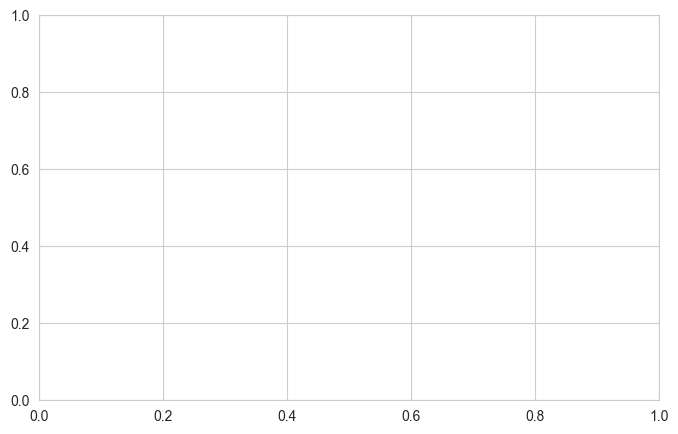

In [98]:
fig2, ax1 = plt.subplots(figsize=(8, 5))
sns.regplot(x='release_force_target', y='ls3_rope_release', data=df_id, ax=ax1, color='b', ci=95)
ax2 = ax1.twinx()
ax2.axis('off')
stats_text = annotate_stats(df_id['release_force_target'], df_id['ls3_rope_release'])
ax2.annotate(stats_text, xy=(1.01, 0.1), xycoords='axes fraction')
#ax1.set_title('Correlation Between Target and Actual Release Forces"')
ax1.set_xlabel('Release Force Target [kN]')
ax1.set_ylabel('Release Force [kN]')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig2, filename=f"release_force_target_vs_ls3_rope_release", subdir="combined")

#### Zusammenhang Vorspannung und resultierende Lastspitzen

In [ ]:
fig3, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax2.axis('off')
y_pos_init = 0.1
for idx, (treatment, color) in enumerate(treatment_color_dict.items()):
    subset = df_id[df_id['treatment'] == treatment]
    if subset['ls3_cable_max'].isna().all():
        continue
    sns.regplot(x='ls3_rope_release', y='ls3_cable_max', data=subset, ax=ax1, color=color, label=treatment, ci=95)
    stats_text = annotate_stats(subset['ls3_rope_release'], subset['ls3_cable_max'])
    ax2.annotate(f"{treatment}:\n{stats_text}", xy=(1.01, y_pos_init + idx * 0.3), xycoords='axes fraction')
#ax1.set_title('Correlation Between Release Force and Peak Cable Force')
ax1.set_xlabel('Release Force [kN]')
ax1.set_ylabel('Peak Force in Cable [kN]')
ax1.legend(title='Treatment', loc='upper left')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig3, filename=f"release_force_vs_ls3_cable_max", subdir="combined")

In [ ]:
fig3, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax2.axis('off')
y_pos_init = 0.1
for idx, (treatment, color) in enumerate(treatment_color_dict.items()):
    subset = df_id[df_id['treatment'] == treatment]
    if subset['ptq_m_amplitude'].isna().all():
        continue
    sns.regplot(x='ls3_rope_release', y='ptq_m_amplitude', data=subset, ax=ax1, color=color, label=treatment,
                ci=95)
    stats_text = annotate_stats(subset['ls3_rope_release'], subset['ptq_m_amplitude'])
    ax2.annotate(f"{treatment}:\n{stats_text}", xy=(1.01, y_pos_init + idx * 0.3), xycoords='axes fraction')
#ax1.set_title('Correlation Between Release Force and Elongation Amplitude')
ax1.set_xlabel('Release Force [kN]')
ax1.set_ylabel('Elongation Amplitude [$\mu$m] (mean for all Sensors)')
ax1.legend(title='Treatment', loc='upper left')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig3, filename=f"ls3_release_force_vs_ptq_m_amplitude", subdir="combined")


In [ ]:
fig3, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
ax2.axis('off')
y_pos_init = 0.1
for idx, (treatment, color) in enumerate(treatment_color_dict.items()):
    subset = df_id[df_id['treatment'] == treatment]
    if subset['ptq_m_amplitude_2'].isna().all():
        continue
    sns.regplot(x='ls3_rope_release', y='ptq_m_amplitude_2', data=subset, ax=ax1, color=color, label=treatment,
                ci=95)
    stats_text = annotate_stats(subset['ls3_rope_release'], subset['ptq_m_amplitude_2'])
    ax2.annotate(f"{treatment}:\n{stats_text}", xy=(1.01, y_pos_init + idx * 0.3), xycoords='axes fraction')
#ax1.set_title('Correlation Between Release Force and Elongation Amplitude 2')
ax1.set_xlabel('Release Force [kN]')
ax1.set_ylabel('Elongation Amplitude 2 [$\mu$m] (mean for all Sensors)')
ax1.legend(title='Treatment', loc='upper left')
plt.tight_layout()
plt.show()
PLOT_MANAGER.save_plot(fig3, filename=f"ls3_release_force_vs_ptq_m_amplitude_2", subdir="combined")

In [ ]:
# Funktion zur Durchführung des ANOVA-Tests und Berechnung der Effektstärke (Eta Squared)
def perform_anova_and_effect_size(df: pd.DataFrame, variable: str, treatments: List[str]) -> str:
    groups = [df[df['treatment'] == treatment][variable].dropna() for treatment in treatments]
    f_stat, p_value = f_oneway(*groups)

    # Berechnung der Effektstärke (Eta Squared)
    n = sum([len(g) for g in groups])
    ss_total = sum([(x - df[variable].mean()) ** 2 for g in groups for x in g])
    eta_squared = f_stat * len(groups) / (f_stat * len(groups) + (n - len(groups)))

    # Überprüfung der Signifikanz
    significance = "*" if p_value < 0.05 else ""

    return f"{variable}: {significance}\nF-statistic = {f_stat:.2f}\np-value = {p_value:.2e}\nEta Squared = {eta_squared:.2f}"

In [ ]:
# Funktion zur Erstellung von Boxplots
def create_boxplot(df: pd.DataFrame, variable: str, group_by: str, ax: plt.Axes, color_dict: Dict[str, str], perform_stats: bool) -> None:
    valid_df = df.dropna(subset=[variable])
    sns.boxplot(x=group_by, y=variable, hue=group_by, data=valid_df, ax=ax, palette=color_dict, dodge=False)
    ax2 = ax.twinx()
    ax2.axis('off')
    if perform_stats:
        stats_text = perform_anova_and_effect_size(valid_df, variable, valid_df[group_by].unique())
        ax2.annotate(stats_text, xy=(1.01, 0.1), xycoords='axes fraction')
    ax.set_title(f'Einfluss von {group_by} auf {variable}')
    ax.set_xlabel(group_by)
    ax.set_ylabel(variable)

# Funktion zur Erstellung kombinierter Plots
def create_combined_plot(df: pd.DataFrame, columns: List[str], group_by: str, color_dict: Dict[str, str], num_columns: int = 3, perform_stats: bool = False) -> None:
    num_rows = len(columns) // num_columns + (len(columns) % num_columns > 0)
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 4 * num_rows))
    axes = axes.flatten()

    for idx, variable in enumerate(columns):
        create_boxplot(df, variable, group_by, axes[idx], color_dict, perform_stats)

    plt.tight_layout()
    plt.show()
    PLOT_MANAGER.save_plot(fig, filename=f"combined_plot_{group_by}", subdir="combined")

# Funktion zur Erstellung einzelner Plots
def create_individual_plots(df: pd.DataFrame, columns: List[str], group_by: str, color_dict: Dict[str, str], perform_stats: bool = False) -> None:
    for variable in columns:
        fig, ax = plt.subplots(figsize=(8, 5))
        create_boxplot(df, variable, group_by, ax, color_dict, perform_stats)
        plt.tight_layout()
        #plt.show()
        PLOT_MANAGER.save_plot(fig, filename=f"{group_by}_{variable}", subdir="individual_plots")

In [ ]:
columns = ['ptq_m_amplitude',
           'ptq_m_amplitude_2',
           'ptq_initial_amplitude',
           'ptq_damping_coeff',
           'ptq_angular_frequency',
           'ptq_y_shift',
           'ptq_pearson_r',
           #'ptq_nrmse',
           #'ptq_nmae',
           #'release_force_target',
           'ls3_rope_release',
           'ls3_cable_max'
           ]

# Beispiel: Erstellen von Plots gruppiert nach 'treatment'
create_combined_plot(df, columns, 'treatment', treatment_color_dict, perform_stats=True)
create_individual_plots(df, columns, 'treatment', treatment_color_dict, perform_stats=True)

In [ ]:
# Beispiel: Erstellen von Plots gruppiert nach 'ptq_sensor_name'
columns = ['ptq_m_amplitude', 'ptq_m_amplitude_2', 'ptq_initial_amplitude', 'ptq_damping_coeff', 'ptq_angular_frequency', 'ptq_pearson_r']

create_combined_plot(df, columns, 'ptq_sensor_name', sensor_color_dict)
create_individual_plots(df, columns, 'ptq_sensor_name', sensor_color_dict)